# Introduction

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load and Describe Data

## Load Data

In [2]:
url = 'train.csv'
df = pd.read_csv(url) 
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


## Data Description

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Check Null and Missing Values

In [4]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage


## Numerical Data

In [5]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(df.select_dtypes(include=numerics).columns)
print(df.select_dtypes(include=numerics).shape)
data_num = df.select_dtypes(include=numerics)
data_num.head(3)

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

(381109, 9)


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,40454.0,26.0,217,1
1,2,76,1,3.0,0,33536.0,26.0,183,0
2,3,47,1,28.0,0,38294.0,26.0,27,1


## Non Numerical Data

In [6]:
display(df.select_dtypes(include=['object']).columns)
print(df.select_dtypes(include=object).shape)
data_cat = df.select_dtypes(include=['object'])
data_cat.head(3)

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

(381109, 3)


,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes


# Data Preparation

## Transform categorical variables

### Check Cardinality

In [7]:
col_cat = list(data_cat)
for i in col_cat:
    print(i, ' ---UNIQUE VALUE--  ',len(df[i].unique()))

Gender  ---UNIQUE VALUE--   2
Vehicle_Age  ---UNIQUE VALUE--   3
Vehicle_Damage  ---UNIQUE VALUE--   2


## EDA

In [8]:
df[['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']].describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


### Box Plot Numerical Feature

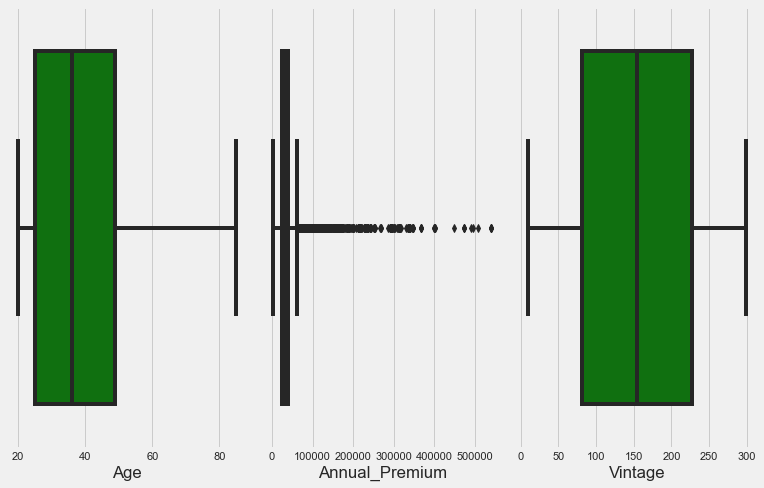

In [9]:
features = ['Age', 'Annual_Premium', 'Vintage']
plt.figure(figsize=(25, 7))
for i in range(0, len(features)):
    plt.subplot(1, 7, i+1)
    sns.boxplot(df[features[i]],color='green',orient='v')
    plt.tight_layout()

### Distribution Plot

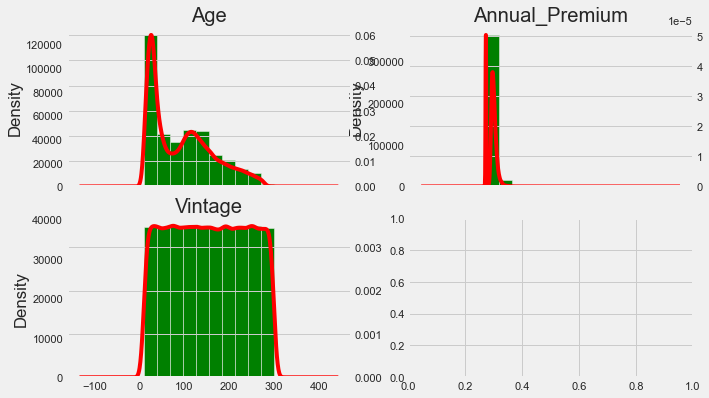

In [10]:
df_num = df[features]
k = len(df_num.columns)
n = 2
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(df_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax, color='green')
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='red')
    ax2.set_ylim(0)


### Bar Plot Response

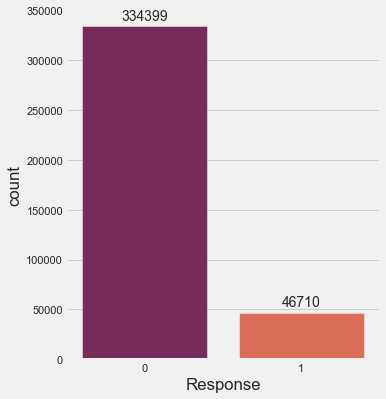

In [11]:
plt.figure(figsize=(5,6))
ax = sns.countplot(x='Response', data=df, palette='rocket')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()),
                    xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                    xytext=(0, 3),fontsize=14,
                    textcoords="offset points",
                    ha='center', va='bottom')

### Distribution Plot Feature Age

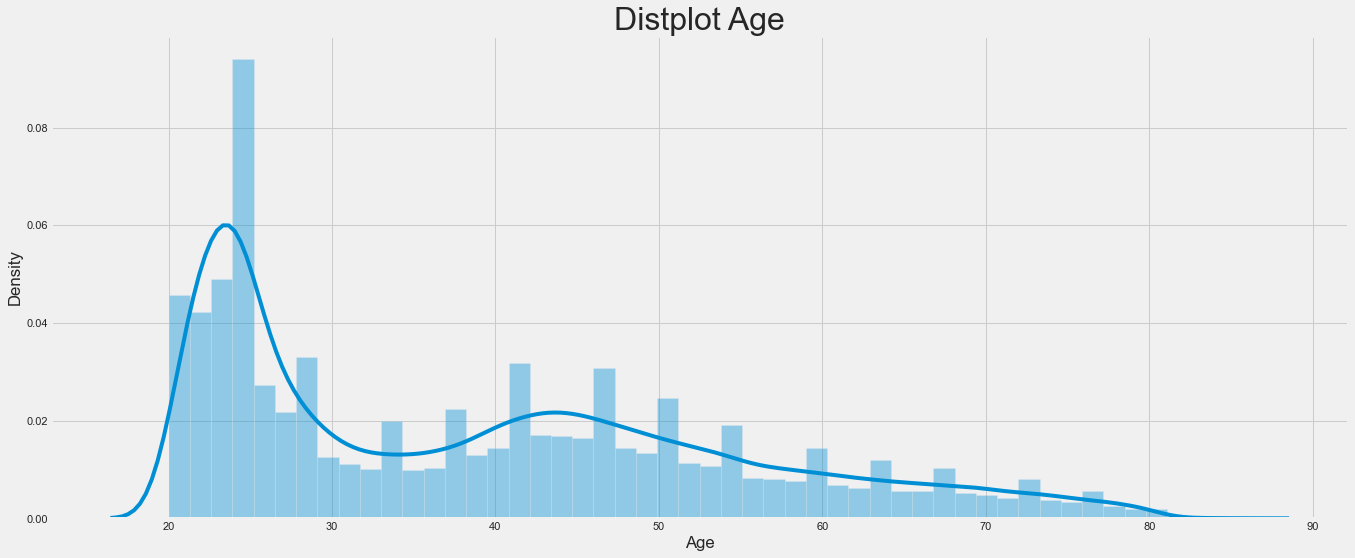

In [12]:
sns.distplot(df['Age']);
plt.title('Distplot Age', fontsize = 32);

### Response by Age

In [13]:
gr_age = []
for i, kolom in df.iterrows():
    if kolom['Age'] >= 20 and kolom['Age'] <= 29:
        segment = '20s'
    elif kolom['Age'] >= 30 and kolom['Age'] <= 39:
        segment = '30s'
    elif kolom['Age'] >= 40 and kolom['Age'] <= 49:
        segment = '40s'
    elif kolom['Age'] >= 50 and kolom['Age'] <= 59:
        segment = '50s'
    elif kolom['Age'] >= 60 and kolom['Age'] <= 69:
        segment = '60s'
    elif kolom['Age'] >= 70 and kolom['Age'] <= 79:
        segment = '70s'
    else:
        segment = '80s'
    gr_age.append(segment)
    
df['Group_Age'] = gr_age
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Group_Age
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,40s
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,70s
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,40s
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,20s
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,20s


Text(0, 0.5, 'Response')

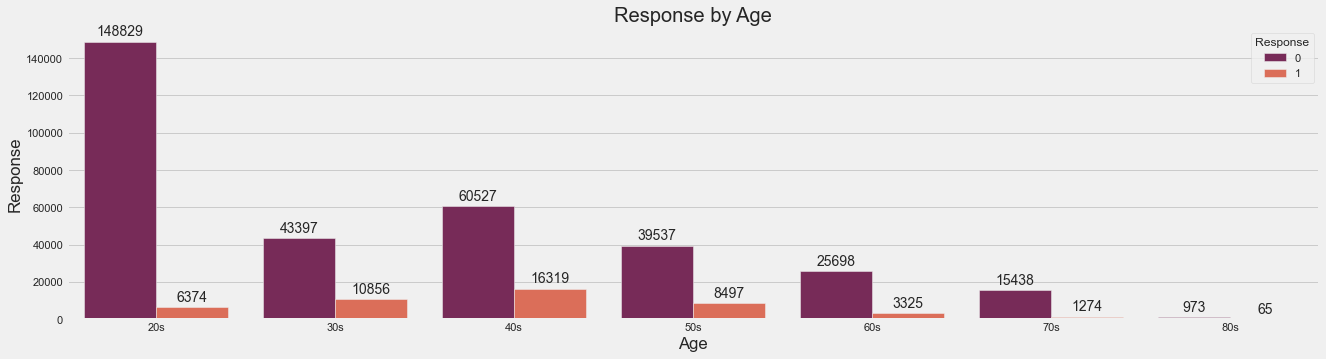

In [14]:
plt.figure(figsize=(20,5))
dfs = df.sort_values('Group_Age', ascending=True)
ax = sns.countplot(x='Group_Age',hue='Response',data=dfs,palette='rocket')
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()),
              xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(0, 3),fontsize=14,
              textcoords="offset points",
              ha='center', va='bottom')
ax.set_title('Response by Age')
ax.set_xlabel('Age')
ax.set_ylabel('Response')

### Annual Premium

<AxesSubplot:>

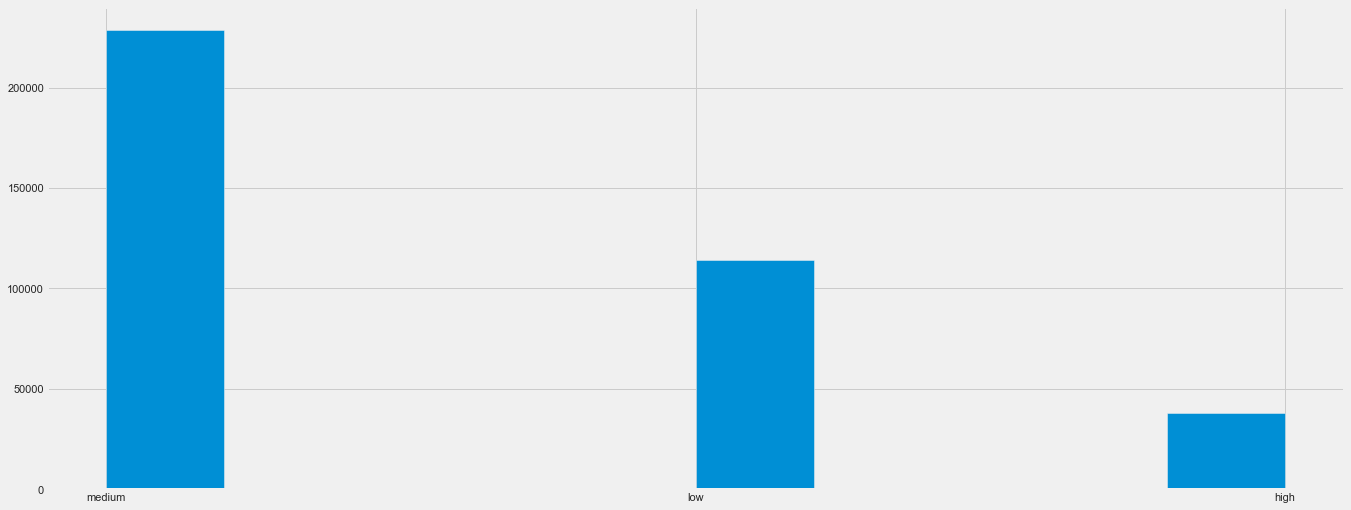

In [15]:
bins = np.percentile(df['Annual_Premium'],[0,30,90,100])
df['spender'] = pd.cut(df['Annual_Premium'],bins=bins,labels=['low', 'medium', 'high'], include_lowest=True)
df['spender'].hist()

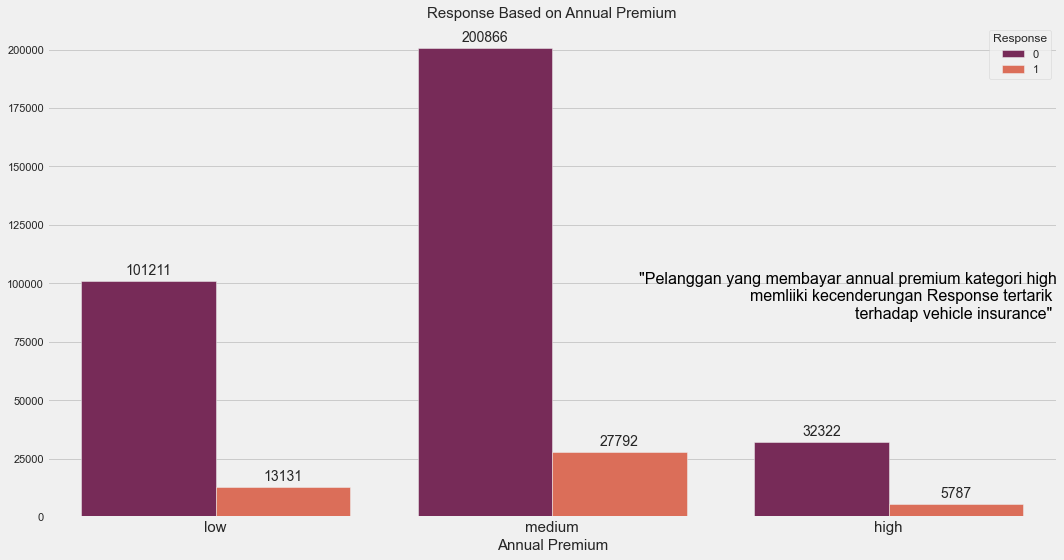

In [16]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='spender', data=df, hue='Response',palette='rocket')
text = '''
"Pelanggan yang membayar annual premium kategori high
memliiki kecenderungan Response tertarik 
terhadap vehicle insurance" 

'''
ax.text(2.5,70000,text,horizontalalignment='right',color='black',fontsize=16,fontweight='normal')
ax.set_title('Response Based on Annual Premium', fontsize=15)
ax.set_xlabel('Annual Premium', fontsize= 15)
ax.set_ylabel('')
plt.xticks(fontsize=15)
plt.tight_layout()
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()),
                    xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                    xytext=(0, 3),fontsize=14,
                    textcoords="offset points",
                    ha='center', va='bottom')

### Gender

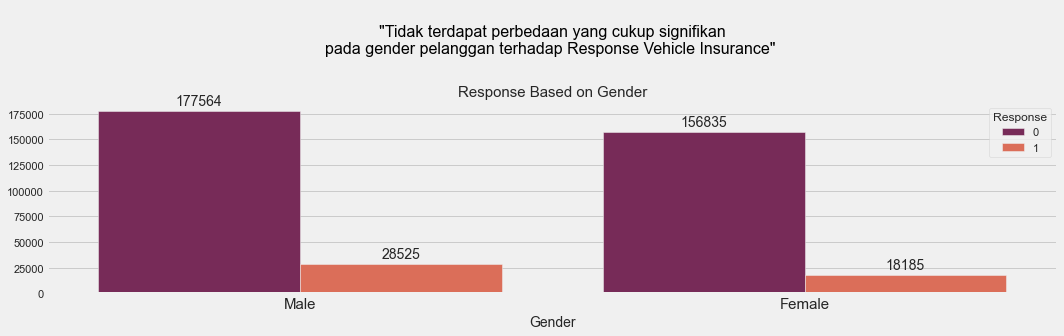

In [17]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x='Gender', data=df, hue='Response',palette='rocket')
text = '''
"Tidak terdapat perbedaan yang cukup signifikan
pada gender pelanggan terhadap Response Vehicle Insurance" 

'''
ax.text(0.5,200000,text,horizontalalignment='center',color='black',fontsize=16,fontweight='normal')
ax.set_title('Response Based on Gender', fontsize=15)
ax.set_xlabel('Gender', fontsize= 14)
ax.set_ylabel('')
plt.xticks(fontsize=15)
plt.tight_layout()
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()),
                    xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                    xytext=(0, 3),fontsize=14,
                    textcoords="offset points",
                    ha='center', va='bottom')

### Response Based on Vehicle Age

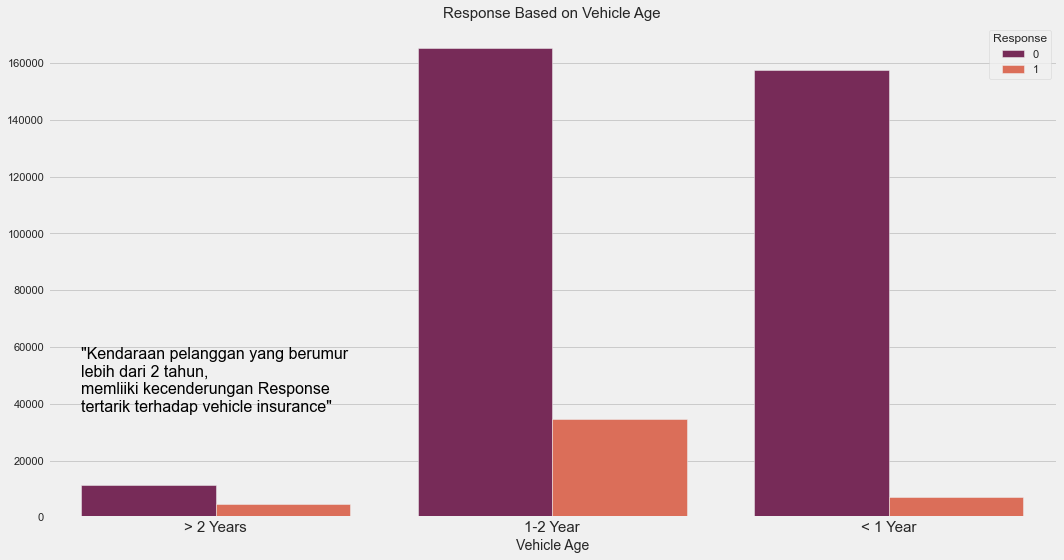

In [18]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Vehicle_Age', data=df, hue='Response',palette='rocket')
text = '''
"Kendaraan pelanggan yang berumur 
lebih dari 2 tahun,
memliiki kecenderungan Response 
tertarik terhadap vehicle insurance" 

'''
ax.text(-0.4,25000,text,horizontalalignment='left',color='black',fontsize=16,fontweight='normal')

ax.set_title('Response Based on Vehicle Age', fontsize=15)
ax.set_xlabel('Vehicle Age', fontsize= 14)
ax.set_ylabel('')
plt.xticks(fontsize=15)
plt.tight_layout()

### Region Code

Text(0, 0.5, '')

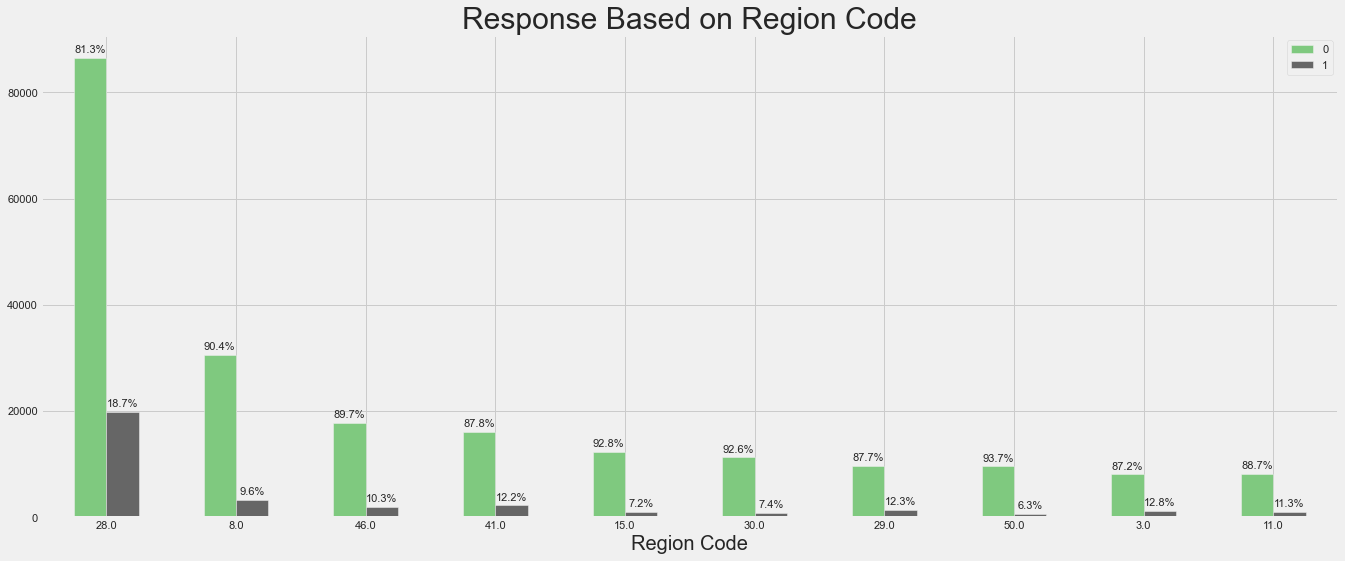

In [19]:
ct = pd.crosstab(df['Region_Code'], df['Response']).reset_index()
ct = pd.DataFrame(data = ct.iloc[:,1:].values,index = ct.iloc[:,0:1].values.flatten(), columns = [0,1])
ct['count'] = ct[0] + ct[1]
ct2 = ct.sort_values('count', ascending=False).head(10)
ax = ct2[[0,1]].plot(kind='bar', rot=0, cmap='Accent')
x = 0
for p in ax.patches:
    for i in range(len(ct2['count'].values)):
        num = ct2['count'].values[x]
        x += 1
        if x > 9:
            x = 0
        break
    ax.annotate('{0:.1f}%'.format(p.get_height()*100/num),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 3),fontsize=11,
                textcoords="offset points",
                ha='center', va='bottom')
ax.set_title('Response Based on Region Code', fontsize=30)
ax.set_xlabel('Region Code', fontsize=20)
ax.set_ylabel('')

### Response Based on Vehicle Damage

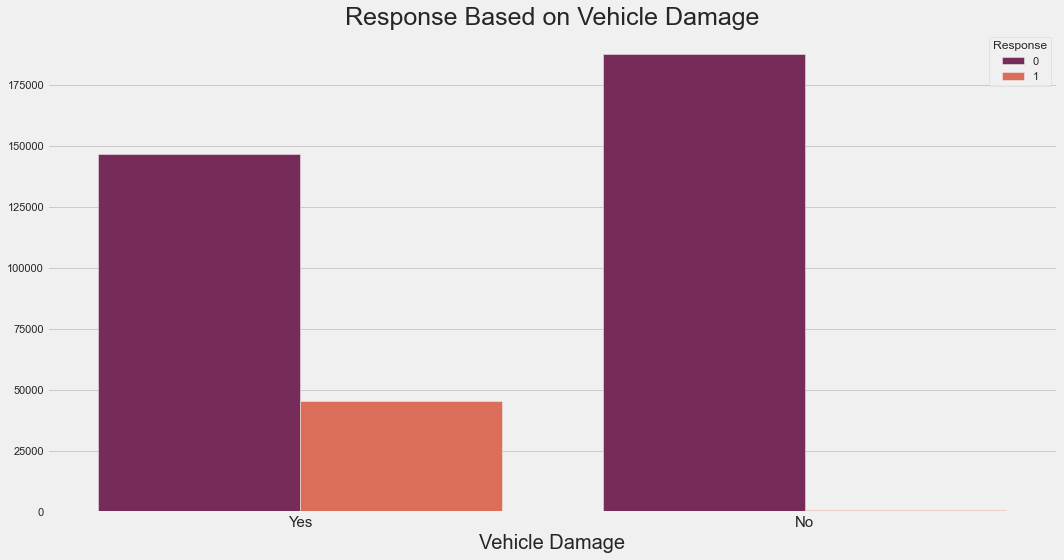

In [20]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Vehicle_Damage', data=df, hue='Response',palette='rocket')
ax.set_title('Response Based on Vehicle Damage', fontsize=25)
ax.set_xlabel('Vehicle Damage', fontsize=20)
ax.set_ylabel('')
plt.xticks(fontsize=15)
plt.tight_layout()

### Response Based on Driving License Feature

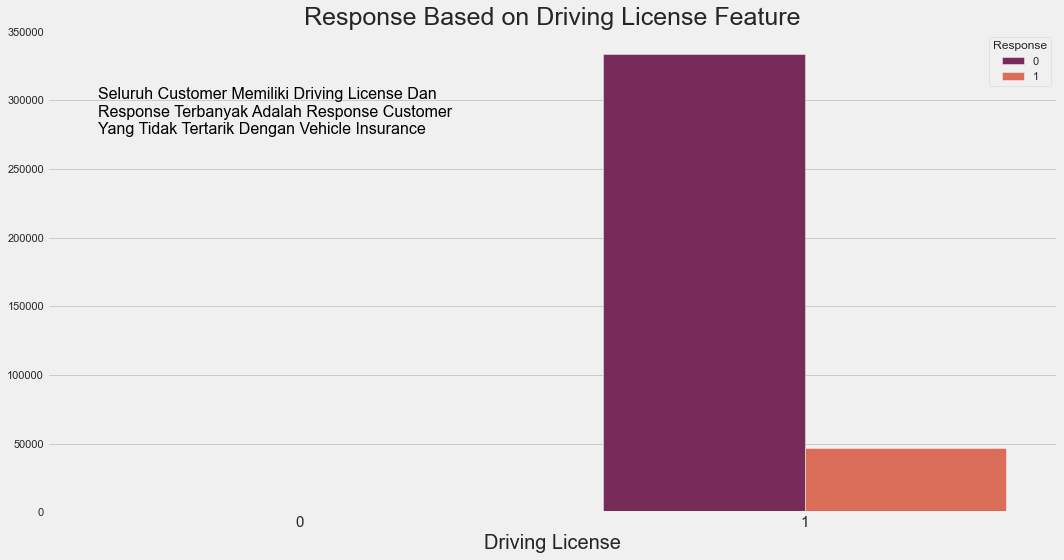

In [21]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Driving_License', data=df, hue='Response',palette='rocket')
text = '''
Seluruh Customer Memiliki Driving License Dan 
Response Terbanyak Adalah Response Customer
Yang Tidak Tertarik Dengan Vehicle Insurance

'''
ax.text(-0.4,250000,text,horizontalalignment='left',color='black',fontsize=16,fontweight='normal')
ax.set_title('Response Based on Driving License Feature', fontsize=25)
ax.set_xlabel('Driving License', fontsize=20)
ax.set_ylabel('')
plt.xticks(fontsize=15)
plt.tight_layout()

### Previously Injured

In [22]:
def percentage_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.1
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            plot.annotate(percentage, (x, y), size = 12, va='bottom')
    plt.show()

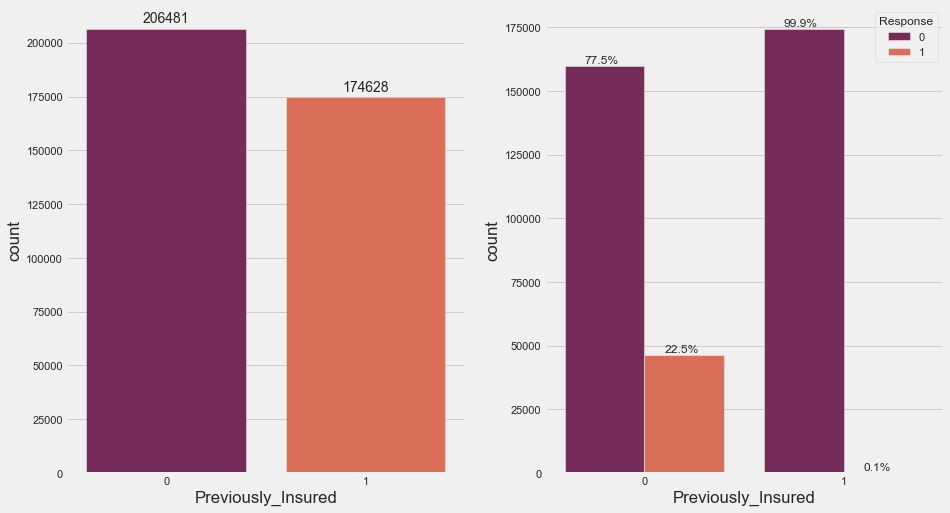

In [23]:
fig,ax = plt.subplots(1,2,figsize=(14,8))

ax1 = sns.countplot(x='Previously_Insured', data=df, palette='rocket', ax=ax[0])
for p in ax1.patches:
        ax1.annotate('{}'.format(p.get_height()),
                    xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                    xytext=(0, 3),fontsize=14,
                    textcoords="offset points",
                    ha='center', va='bottom')

ax2 = sns.countplot(x='Previously_Insured', hue='Response', data=df, palette='rocket', ax=ax[1])
percentage_hue(ax2, df['Previously_Insured'], 2,2)

*customer yang memiliki asuransi kendaraan jumlahnya lebih sedikit dibanding yang belum memiliki asuransi kendaraan  
*orang yang belum memiliki asuransi kendaraan cenderung menerima asuransi kendaraan dari company

### Vintage

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

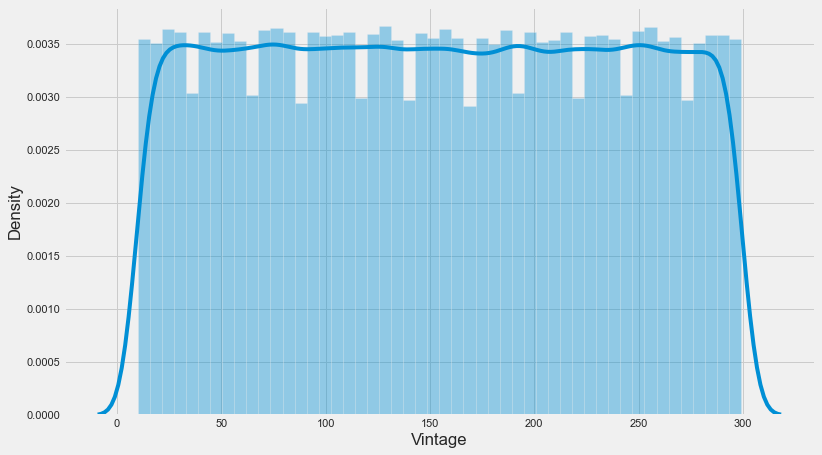

In [24]:
plt.figure(figsize=(12,7))
sns.distplot(df['Vintage'])

### Policy Salaes Channels

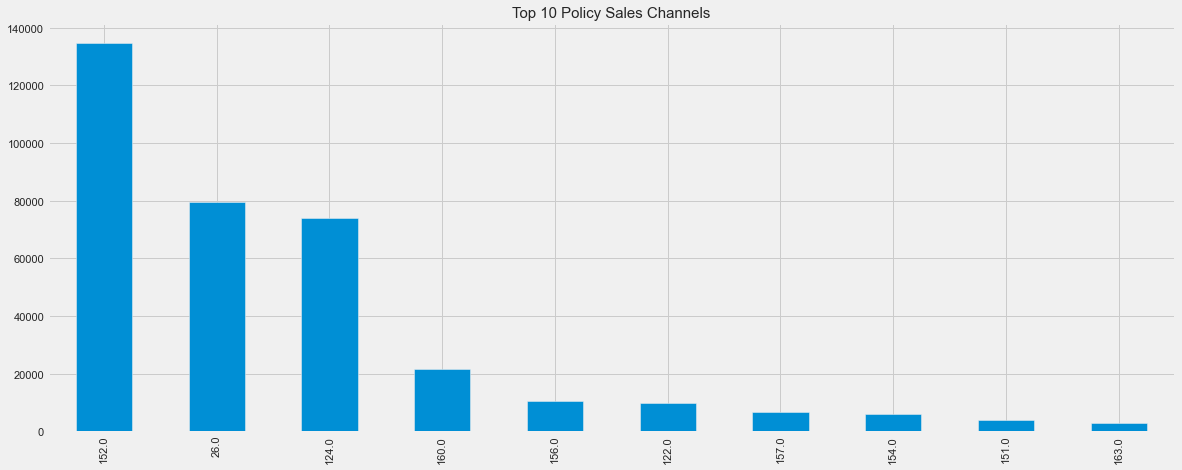

In [25]:
plt.figure(figsize=(18, 7))
df['Policy_Sales_Channel'].value_counts().head(10).plot.bar()

plt.title('Top 10 Policy Sales Channels', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

### Policy Sales Channel

Text(0, 0.5, '')

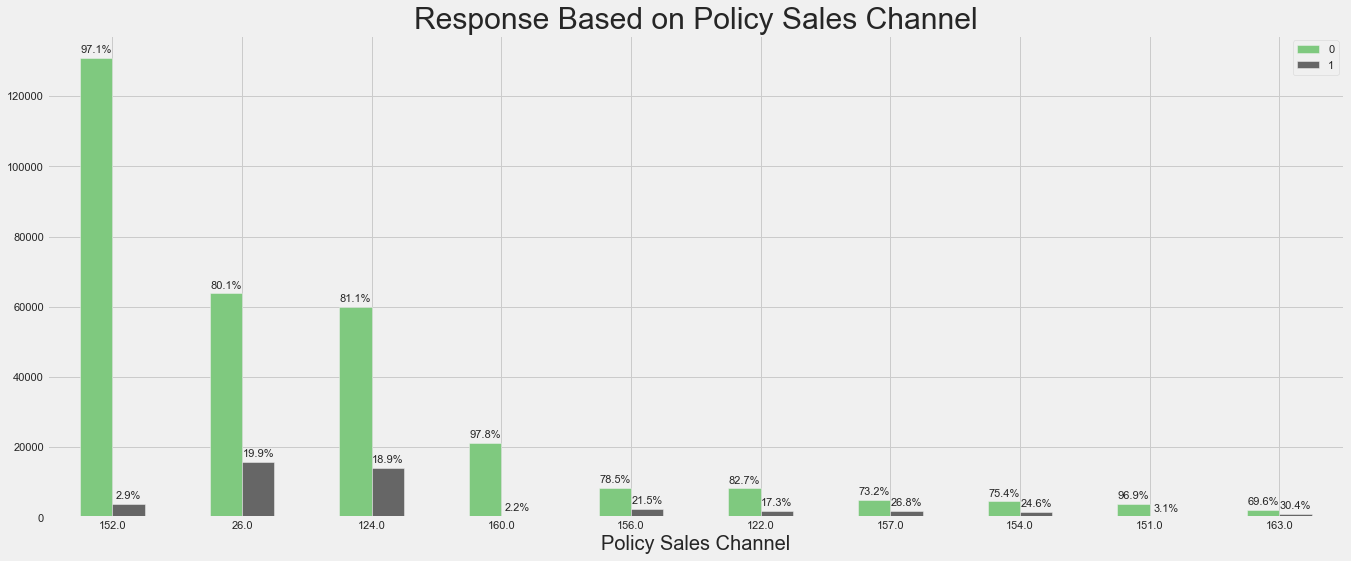

In [26]:
ct = pd.crosstab(df['Policy_Sales_Channel'], df['Response']).reset_index()
ct = pd.DataFrame(data = ct.iloc[:,1:].values,index = ct.iloc[:,0:1].values.flatten(), columns = [0,1])
ct['count'] = ct[0] + ct[1]
ct2 = ct.sort_values('count', ascending=False).head(10)
ax = ct2[[0,1]].plot(kind='bar', rot=0, cmap='Accent')
x = 0
for p in ax.patches:
    for i in range(len(ct2['count'].values)):
        num = ct2['count'].values[x]
        x += 1
        if x > 9:
            x = 0
        break
    ax.annotate('{0:.1f}%'.format(p.get_height()*100/num),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 3),fontsize=11,
                textcoords="offset points",
                ha='center', va='bottom')
ax.set_title('Response Based on Policy Sales Channel', fontsize=30)
ax.set_xlabel('Policy Sales Channel', fontsize=20)
ax.set_ylabel('')

* Policy sales channels yang sering digunakan oleh company adalah 152, 26, 124
* Policy sales channels 152 sering digunakan namun memiliki sering tidak diresponse oleh customer, dan tidak begitu menarik bagi customer
* Policy sales channles 26 dan 124 walau tidak banyk digunakan seperti 152 namun memiliki tingkat ketertarikan yang tinggi bagi customer


## Feature Engineering

In [27]:
url = 'https://raw.githubusercontent.com/akbarulazis/hicsp/main/train.csv'
df = pd.read_csv(url) 
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [28]:
df_feat = df

### Grouping Feature "Age"

In [29]:
gr_age = []
for i, kolom in df_feat.iterrows():
    if kolom['Age'] >= 20 and kolom['Age'] <= 29:
        segment = 1
    elif kolom['Age'] >= 30 and kolom['Age'] <= 39:
        segment = 2
    elif kolom['Age'] >= 40 and kolom['Age'] <= 49:
        segment = 3
    elif kolom['Age'] >= 50 and kolom['Age'] <= 59:
        segment = 4
    elif kolom['Age'] >= 60 and kolom['Age'] <= 69:
        segment = 5
    elif kolom['Age'] >= 70 and kolom['Age'] <= 79:
        segment = 6
    else:
        segment = 7
    gr_age.append(segment)
    
df_feat['Group_Age'] = gr_age
df_feat.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Group_Age
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,3
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,6
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,3
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,1
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,1


### One Hot Encoding

In [30]:
df_feat = pd.get_dummies(df_feat, columns=['Gender'], drop_first=True)
df_feat = pd.get_dummies(df_feat, columns=['Vehicle_Damage'], drop_first=True)
df_feat = pd.get_dummies(df_feat, columns=['Vehicle_Age'], drop_first=True)

In [31]:
df_feat.head(10)

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Group_Age,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,44,1,28.0,0,40454.0,26.0,217,1,3,1,1,0,1
1,2,76,1,3.0,0,33536.0,26.0,183,0,6,1,0,0,0
2,3,47,1,28.0,0,38294.0,26.0,27,1,3,1,1,0,1
3,4,21,1,11.0,1,28619.0,152.0,203,0,1,1,0,1,0
4,5,29,1,41.0,1,27496.0,152.0,39,0,1,0,0,1,0
5,6,24,1,33.0,0,2630.0,160.0,176,0,1,0,1,1,0
6,7,23,1,11.0,0,23367.0,152.0,249,0,1,1,1,1,0
7,8,56,1,28.0,0,32031.0,26.0,72,1,4,0,1,0,0
8,9,24,1,3.0,1,27619.0,152.0,28,0,1,0,0,1,0
9,10,32,1,6.0,1,28771.0,152.0,80,0,2,0,0,1,0


### Drop ID and Age

In [32]:
df_feat = df_feat.drop(['id', 'Age'], axis=1)

In [33]:
df_feat.head()

,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Group_Age,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,28.0,0,40454.0,26.0,217,1,3,1,1,0,1
1,1,3.0,0,33536.0,26.0,183,0,6,1,0,0,0
2,1,28.0,0,38294.0,26.0,27,1,3,1,1,0,1
3,1,11.0,1,28619.0,152.0,203,0,1,1,0,1,0
4,1,41.0,1,27496.0,152.0,39,0,1,0,0,1,0


### Split

In [34]:
x = df_feat.drop(['Response'],axis=1)
y = df_feat['Response']

### Standard Scaler

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [36]:
df_scaled = scaler.fit_transform(df_feat.drop('Response', axis=1))

In [37]:
X = df_scaled
y = df_feat['Response']

### Train Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=101)


## Modelling

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, plot_confusion_matrix,precision_score

In [40]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

### Logistik Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [43]:
LogPred = logmodel.predict(X_test)

In [44]:
LogPredProb = logmodel.predict_proba(X_test)[:,1]

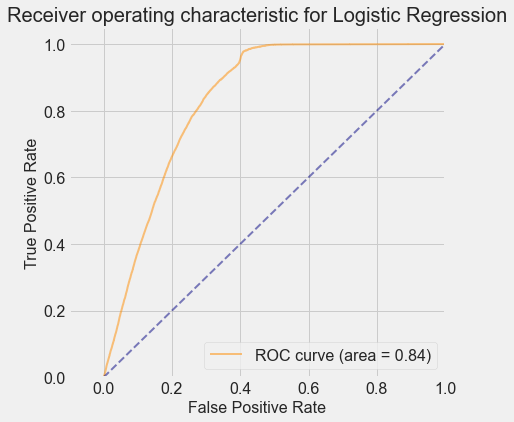

In [45]:
(fpr, tpr, thresholds) = roc_curve(y_test, LogPredProb)
plot_ROC(fpr, tpr,'Logistic Regression')

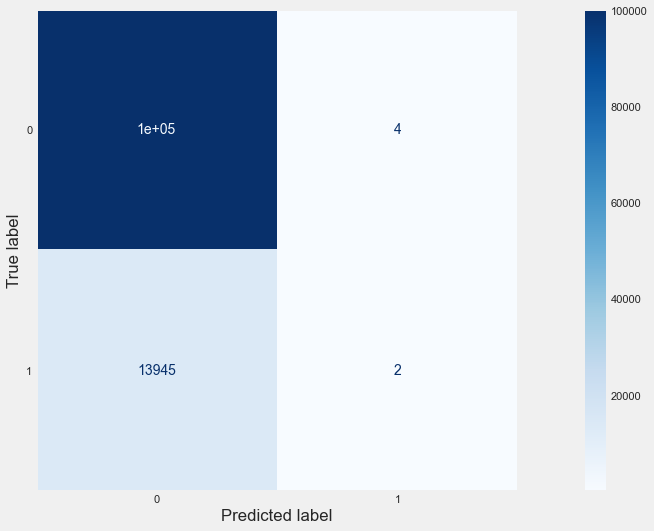

In [46]:
plot_confusion_matrix(logmodel, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [47]:
print(classification_report(y_test,LogPred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100386
           1       0.33      0.00      0.00     13947

    accuracy                           0.88    114333
   macro avg       0.61      0.50      0.47    114333
weighted avg       0.81      0.88      0.82    114333



#### CV Logistik Regression

In [48]:
scores = cross_val_score(logmodel, X_train, y_train, scoring='roc_auc', cv=10)
print('Cross-Validation ROC_AUC Scores', scores)

Cross-Validation ROC_AUC Scores [0.83458981 0.83901443 0.83950953 0.83416874 0.83484973 0.84391025
 0.83455632 0.83568452 0.83807251 0.84154836]


In [49]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.8341687392450554, 0.837590419356907, 0.8439102499694954)

### Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
dtree = DecisionTreeClassifier()

In [52]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [53]:
dtreePred = dtree.predict(X_test)

In [54]:
dtreePredProb = dtree.predict_proba(X_test)[:,1]

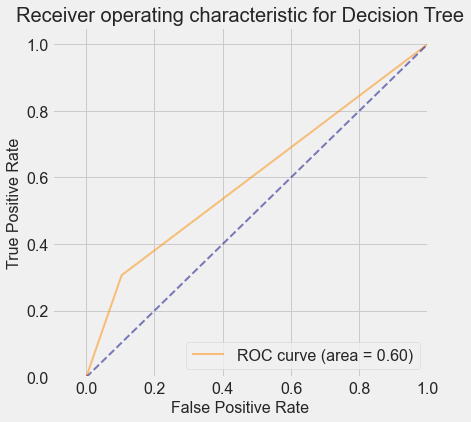

In [55]:
(fpr, tpr, thresholds) = roc_curve(y_test, dtreePredProb)
plot_ROC(fpr, tpr,'Decision Tree')

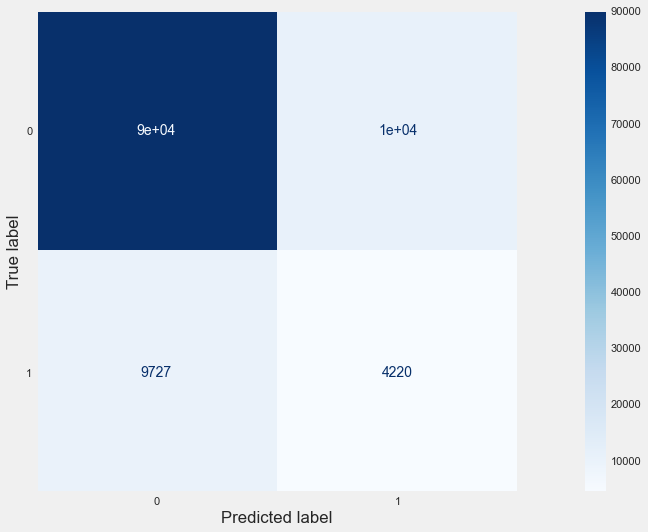

In [56]:
plot_confusion_matrix(dtree, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [57]:
print(classification_report(y_test,LogPred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100386
           1       0.33      0.00      0.00     13947

    accuracy                           0.88    114333
   macro avg       0.61      0.50      0.47    114333
weighted avg       0.81      0.88      0.82    114333



#### CV Decision Tree

In [58]:
scores = cross_val_score(dtree, X_train, y_train, scoring='roc_auc',cv=10)
print('Cross-Validation ROC_AUC Scores', scores)

Cross-Validation ROC_AUC Scores [0.59973492 0.60867686 0.59984343 0.59744613 0.59706083 0.60395553
 0.602305   0.60247396 0.60437437 0.59614559]


In [59]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.5961455890946084, 0.601201662790855, 0.6086768631903662)

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
Rtree = RandomForestClassifier(n_estimators=300)

In [62]:
Rtree.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [63]:
Rtreepred = Rtree.predict(X_test)

In [64]:
RtreepredProb =  Rtree.predict_proba(X_test)[:,1]

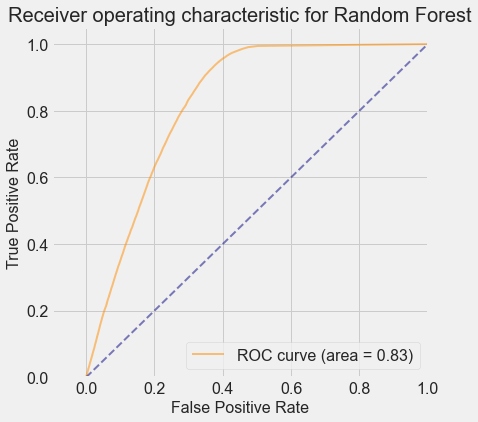

In [65]:
(fpr, tpr, thresholds) = roc_curve(y_test, RtreepredProb)
plot_ROC(fpr, tpr,'Random Forest')

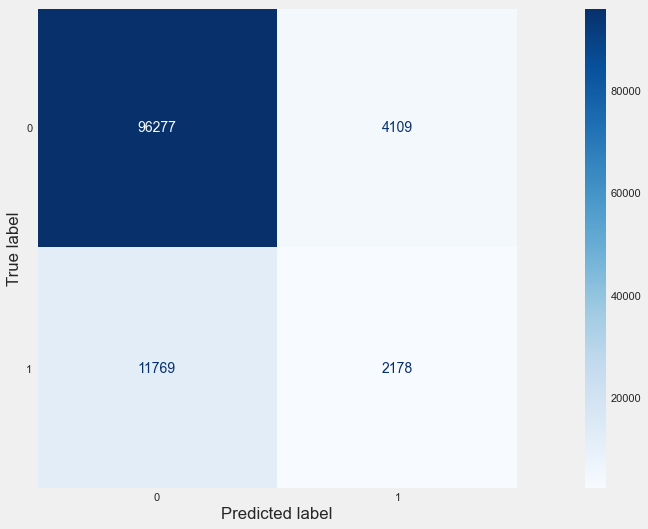

In [66]:
plot_confusion_matrix(Rtree, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [67]:
print(classification_report(y_test,Rtreepred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    100386
           1       0.35      0.16      0.22     13947

    accuracy                           0.86    114333
   macro avg       0.62      0.56      0.57    114333
weighted avg       0.82      0.86      0.84    114333



#### CV Random Forest

In [68]:
scores = cross_val_score(Rtree, X_train, y_train, scoring='roc_auc', cv=10)
print('Cross-Validation ROC_AUC Scores', scores)

Cross-Validation ROC_AUC Scores [0.83011313 0.8335359  0.82897647 0.82762294 0.82529765 0.83445764
 0.82811622 0.82948357 0.83348128 0.82889118]


In [69]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.8252976455901584, 0.8299975988276778, 0.8344576350885061)

### XGBOOTS MODEL

In [70]:
xgb_model=xgb.XGBClassifier()
xgb_model.fit(X_train,y_train)
#change the hyperparams

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
XGBpred = xgb_model.predict_proba(X_test)[:,1]

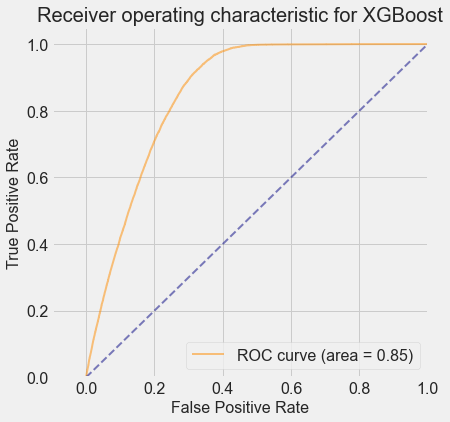

In [72]:
(fpr, tpr, thresholds) = roc_curve(y_test, XGBpred)
plot_ROC(fpr, tpr,'XGBoost')

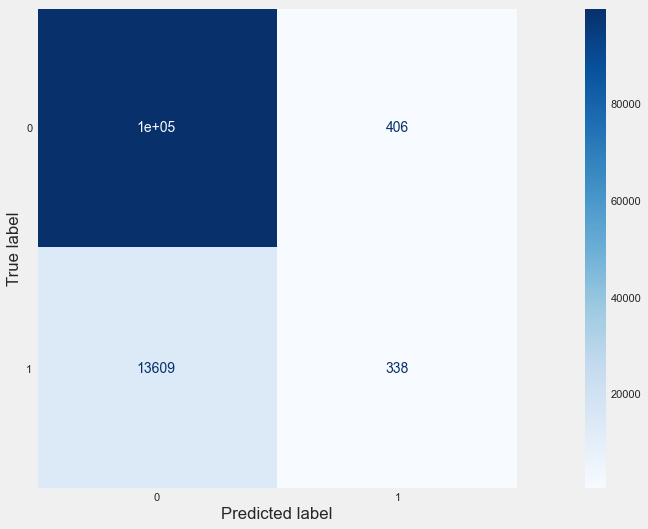

In [73]:
plot_confusion_matrix(xgb_model, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()


In [74]:
print(classification_report(y_test,XGBpred>0.5))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100386
           1       0.45      0.02      0.05     13947

    accuracy                           0.88    114333
   macro avg       0.67      0.51      0.49    114333
weighted avg       0.83      0.88      0.83    114333



#### CV XGBOOST

In [75]:
scores = cross_val_score(xgb_model, X_train, y_train,scoring='roc_auc', cv=10)
print('Cross-Validation ROC_AUC Scores', scores)

Cross-Validation ROC_AUC Scores [0.85333398 0.85687479 0.85267569 0.85002306 0.84945844 0.85566506
 0.85284032 0.85440948 0.85556664 0.85248162]


In [76]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.8494584415687553, 0.8533329078351015, 0.8568747881039566)

# Tuning HyperParameter XGBoost

In [77]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [78]:
space={ 'max_depth': hp.quniform("max_depth", 3,18,1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 300,
        'seed': 0
      }

In [79]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, pred>0.5)
    Roc_Auc_Score = roc_auc_score(y_test, y_score)
    print ("ROC-AUC Score:",Roc_Auc_Score)
    print ("SCORE:", accuracy)
    return {'loss': -Roc_Auc_Score, 'status': STATUS_OK }

In [80]:
trials = Trials()

In [81]:
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

ROC-AUC Score:                                         
0.8348433560831043                                     
SCORE:                                                 
0.8780142216158064                                     
ROC-AUC Score:                                                                    
0.8345398920488132                                                                
SCORE:                                                                            
0.8780142216158064                                                                
ROC-AUC Score:                                                                    
0.8357679451959448                                                                
SCORE:                                                                            
0.8780142216158064                                                                
ROC-AUC Score:                                                                    
0.8337926687806176           

In [82]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8255017098966712, 'gamma': 1.6331807156755782, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_alpha': 40.0, 'reg_lambda': 0.46569712565971155}


In [97]:
xgb_model=xgb.XGBClassifier(n_estimators = space['n_estimators'], max_depth = 9, gamma = 1.6331807156755782, reg_lambda = 0.46569712565971155,
                            reg_alpha = 40.0, min_child_weight=2.0,colsample_bytree = 0.8255017098966712)
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8255017098966712,
              gamma=1.6331807156755782, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=9, min_child_weight=2.0, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=40.0,
              reg_lambda=0.46569712565971155, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
XGBpred = xgb_model.predict_proba(X_test)[:,1]

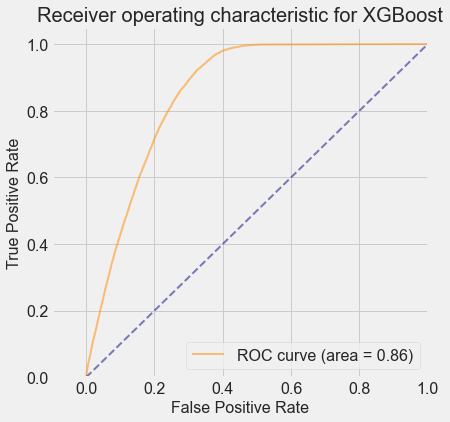

In [99]:
(fpr, tpr, thresholds) = roc_curve(y_test, XGBpred)
plot_ROC(fpr, tpr,'XGBoost')

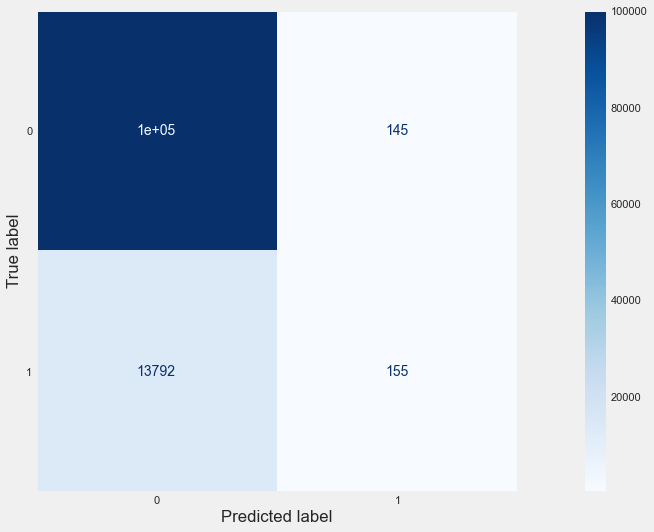

In [100]:
plot_confusion_matrix(xgb_model, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [101]:
print(classification_report(y_test,XGBpred>0.5))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100386
           1       0.52      0.01      0.02     13947

    accuracy                           0.88    114333
   macro avg       0.70      0.50      0.48    114333
weighted avg       0.83      0.88      0.82    114333



# Using Test Case

In [102]:
test = pd.read_csv('test.csv') 
test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265


In [103]:
gr_age = []
for i, kolom in test.iterrows():
    if kolom['Age'] >= 20 and kolom['Age'] <= 29:
        segment = 1
    elif kolom['Age'] >= 30 and kolom['Age'] <= 39:
        segment = 2
    elif kolom['Age'] >= 40 and kolom['Age'] <= 49:
        segment = 3
    elif kolom['Age'] >= 50 and kolom['Age'] <= 59:
        segment = 4
    elif kolom['Age'] >= 60 and kolom['Age'] <= 69:
        segment = 5
    elif kolom['Age'] >= 70 and kolom['Age'] <= 79:
        segment = 6
    else:
        segment = 7
    gr_age.append(segment)
    
test['Group_Age'] = gr_age
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Group_Age
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53,1
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111,3
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199,3
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187,1
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297,1


In [104]:
test = pd.get_dummies(test, columns=['Gender'], drop_first=True)
test = pd.get_dummies(test, columns=['Vehicle_Damage'], drop_first=True)
test = pd.get_dummies(test, columns=['Vehicle_Age'], drop_first=True)

In [105]:
test

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Group_Age,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,381110,25,1,11.0,1,35786.0,152.0,53,1,1,0,1,0
1,381111,40,1,28.0,0,33762.0,7.0,111,3,1,1,0,0
2,381112,47,1,28.0,0,40050.0,124.0,199,3,1,1,0,0
3,381113,24,1,27.0,1,37356.0,152.0,187,1,1,1,1,0
4,381114,27,1,28.0,1,59097.0,152.0,297,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,26,1,37.0,1,30867.0,152.0,56,1,0,0,1,0
127033,508143,38,1,28.0,0,28700.0,122.0,165,2,0,1,0,0
127034,508144,21,1,46.0,1,29802.0,152.0,74,1,1,0,1,0
127035,508145,71,1,28.0,1,62875.0,26.0,265,6,1,0,0,0


In [106]:
test_id = test['id']

In [107]:
test_id

0         381110
1         381111
2         381112
3         381113
4         381114
           ...  
127032    508142
127033    508143
127034    508144
127035    508145
127036    508146
Name: id, Length: 127037, dtype: int64

In [108]:
newId = test_id.to_numpy()

In [109]:
newId = newId.reshape(127037, 1)

In [110]:
test = test.drop(['id', 'Age'], axis=1)

In [111]:
test

,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Group_Age,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,11.0,1,35786.0,152.0,53,1,1,0,1,0
1,1,28.0,0,33762.0,7.0,111,3,1,1,0,0
2,1,28.0,0,40050.0,124.0,199,3,1,1,0,0
3,1,27.0,1,37356.0,152.0,187,1,1,1,1,0
4,1,28.0,1,59097.0,152.0,297,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
127032,1,37.0,1,30867.0,152.0,56,1,0,0,1,0
127033,1,28.0,0,28700.0,122.0,165,2,0,1,0,0
127034,1,46.0,1,29802.0,152.0,74,1,1,0,1,0
127035,1,28.0,1,62875.0,26.0,265,6,1,0,0,0


In [112]:
test_scaled = scaler.fit_transform(test)

## XGBoost Prediction Output

In [113]:
test_xgb_proba = [pred[1] for pred in xgb_model.predict_proba(test_scaled)]

In [114]:
submission_xgb = pd.DataFrame(data = {'id': test_id, 'Response': test_xgb_proba})

In [116]:
submission_xgb.to_csv('submission.csv', index = False)
submission_xgb.head()

,id,Response
0,381110,0.000914
1,381111,0.276827
2,381112,0.292295
3,381113,0.007367
4,381114,0.000816
